In [7]:
!pip install torch torch-geometric scikit-learn matplotlib pandas numpy networkx



  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00


In [8]:
#Applying the ANN Model
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

<ipython-input-13-a8fb228c158a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(


Epoch 0, Loss: 0.6931326985359192, Accuracy: 49.70%
Epoch 10, Loss: 0.48568350076675415, Accuracy: 74.29%
Epoch 20, Loss: 0.40364596247673035, Accuracy: 75.37%
Epoch 30, Loss: 0.36818042397499084, Accuracy: 75.60%
Epoch 40, Loss: 0.3491744101047516, Accuracy: 75.82%
Epoch 50, Loss: 0.3458353579044342, Accuracy: 75.82%
Epoch 60, Loss: 0.34471508860588074, Accuracy: 75.94%
Epoch 70, Loss: 0.3444133400917053, Accuracy: 75.94%
Epoch 80, Loss: 0.3441353142261505, Accuracy: 75.96%
Epoch 90, Loss: 0.3439025580883026, Accuracy: 75.96%
Epoch 100, Loss: 0.34363484382629395, Accuracy: 75.96%
Epoch 110, Loss: 0.3444359600543976, Accuracy: 75.96%
Epoch 120, Loss: 0.3998340666294098, Accuracy: 72.76%
Epoch 130, Loss: 0.3641760051250458, Accuracy: 75.13%
Epoch 140, Loss: 0.35515934228897095, Accuracy: 75.41%
Epoch 150, Loss: 0.349880576133728, Accuracy: 75.65%
Epoch 160, Loss: 0.3476203382015228, Accuracy: 75.80%
Epoch 170, Loss: 0.34671804308891296, Accuracy: 75.84%
Epoch 180, Loss: 0.34613943099975

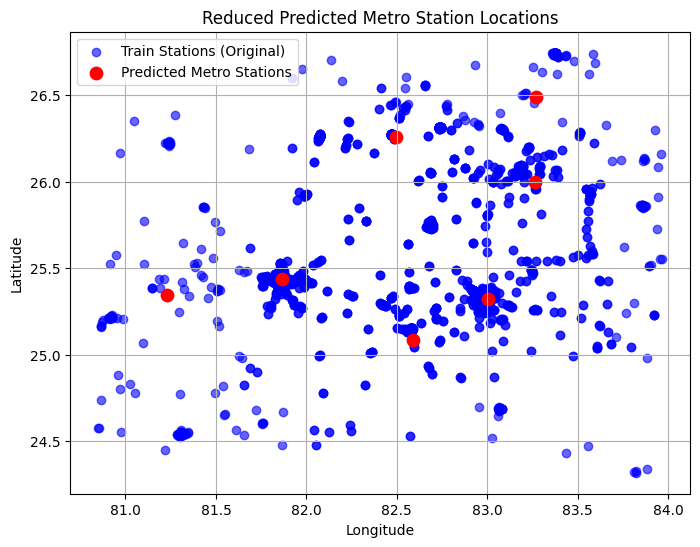

In [13]:

# Load the train data
train_data = pd.read_csv('updated_data_train.csv')

# Encode categorical string columns using OneHotEncoder
string_columns = train_data.select_dtypes(include=['object']).columns
if len(string_columns) > 0:
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid multicollinearity
    encoded_columns = encoder.fit_transform(train_data[string_columns])
    encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(string_columns))
    train_data = pd.concat([train_data.drop(columns=string_columns), encoded_df], axis=1)

# Extract necessary columns (Latitude, Longitude, Population, and any encoded features)
train_coords = train_data[['Latitude', 'Longitude', 'population'] + list(encoded_df.columns)]

# Normalize Latitude, Longitude, and Population using MinMaxScaler
scaler = MinMaxScaler()
train_coords[['Latitude', 'Longitude', 'population']] = scaler.fit_transform(
    train_coords[['Latitude', 'Longitude', 'population']]
)

# Create the graph (G) for the training dataset
G = nx.Graph()
for idx, row in train_coords.iterrows():
    G.add_node(idx, latitude=row['Latitude'], longitude=row['Longitude'], population=row['population'])

# Use Nearest Neighbors to add edges based on geographic proximity
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train_coords[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(train_coords[['Latitude', 'Longitude']])
for i, neighbors in enumerate(indices):
    for j in range(1, len(neighbors)):
        # Compute the absolute difference in population
        population_diff = abs(train_coords['population'].iloc[i] - train_coords['population'].iloc[neighbors[j]])
        # Add the edge with the population difference as weight
        G.add_edge(i, neighbors[j], weight=population_diff)

# Prepare the node features and edges for PyTorch Geometric
node_features = []
for node in G.nodes(data=True):
    # Include all features: latitude, longitude, population, and encoded columns
    node_features.append([node[1]['latitude'], node[1]['longitude'], node[1]['population']])

# Adding additional encoded features to the node features
encoded_features = train_coords.drop(columns=['Latitude', 'Longitude', 'population']).values
node_features = np.concatenate([node_features, encoded_features], axis=1)

edge_index = []
edge_weight = []
for edge in G.edges(data=True):
    edge_index.append([edge[0], edge[1]])
    edge_weight.append(edge[2]['weight'])

# Convert node features, edge index, and edge weights to torch tensors
x = torch.tensor(node_features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight, dtype=torch.float)

# Create the PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Define the GCN model with approximately 10 layers for binary classification
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(x.size(1), 16)  # Adjust input dimension dynamically
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 64)
        self.conv4 = GCNConv(64, 64)
        self.conv5 = GCNConv(64, 32)
        self.conv6 = GCNConv(32, 32)
        self.conv7 = GCNConv(32, 16)
        self.conv8 = GCNConv(16, 16)
        self.conv9 = GCNConv(16, 8)
        self.conv10 = GCNConv(8, 1)  # Single output for binary classification

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = torch.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv2(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv3(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv4(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv5(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv6(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv7(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv8(x, edge_index, edge_weight=edge_weight))
        x = torch.relu(self.conv9(x, edge_index, edge_weight=edge_weight))
        x = torch.sigmoid(self.conv10(x, edge_index, edge_weight=edge_weight))  # Sigmoid activation for binary output
        return x.squeeze()  # Squeeze to make it compatible with BCE loss

# Initialize the model, BCE loss function, and optimizer
model = GCN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Prepare binary target labels (1 for metro station, 0 for non-station)
target = torch.randint(0, 2, (data.num_nodes,), dtype=torch.float)  # Binary labels (0 or 1)

# Train the model with accuracy tracking
epochs = 900
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Forward pass
    loss = criterion(out, target)  # BCE loss
    loss.backward()
    optimizer.step()

    # Calculate accuracy
    with torch.no_grad():
        predicted_labels = (out > 0.5).float()  # Convert probabilities to binary (0 or 1)
        correct = (predicted_labels == target).sum().item()
        accuracy = correct / target.size(0)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

# Post-process: Obtain predictions and threshold them
model.eval()
predicted_probs = model(data).detach().numpy()
predicted_labels = (predicted_probs > 0.5).astype(int)  # Binary labels

# Extract predicted node indices
predicted_indices = np.where(predicted_labels == 1)[0]

# Extract original coordinates (scaled) of predicted metro stations
predicted_coords_scaled = train_coords.iloc[predicted_indices][['Latitude', 'Longitude']].values

# Inverse transform latitude and longitude using only the first two columns of the scaler
predicted_coords = scaler.inverse_transform(
    np.hstack((predicted_coords_scaled, np.zeros((predicted_coords_scaled.shape[0], 1))))
)[:, :2]  # Take only latitude and longitude after inverse transform

# Check if predicted coordinates are empty
if predicted_coords.size == 0:
    print("No metro stations were predicted. Adjust the threshold or check the model output.")
else:
    # Apply KMeans clustering to group predicted metro stations
    num_clusters = min(7, len(predicted_coords))  # Ensure we don't request more clusters than data points
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(predicted_coords)
    reduced_predicted_positions = kmeans.cluster_centers_

    # Clip latitude and longitude values to valid ranges (adjust as per data ranges)
    reduced_predicted_positions[:, 0] = np.clip(reduced_predicted_positions[:, 0],
                                                train_data['Latitude'].min(), train_data['Latitude'].max())
    reduced_predicted_positions[:, 1] = np.clip(reduced_predicted_positions[:, 1],
                                                train_data['Longitude'].min(), train_data['Longitude'].max())

    # Plot the original train data and reduced predicted metro stations
    plt.figure(figsize=(8, 6))
    plt.scatter(train_data['Longitude'], train_data['Latitude'], color='blue', label='Train Stations (Original)', alpha=0.6)
    plt.scatter(reduced_predicted_positions[:, 1], reduced_predicted_positions[:, 0],
                color='red', label='Predicted Metro Stations', s=80)
    plt.title('Reduced Predicted Metro Station Locations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()
